# Lagos House Pricing Recommendation system

## Overview
Finding a house within one's budget in Lagos, Nigeria, is often a stressful and overwhelming process. The city's high property demand, inconsistent pricing, and diverse neighborhoods make it difficult for prospective renters and buyers to find homes that fit their financial capacity. People frequently rely on agents, social media listings, or word of mouth, which can be time-consuming, unreliable, and expensive.

### Problem Statement
Lack of Transparency – Many property listings do not accurately reflect market trends, leading to unrealistic expectations.
Manual Search Process – Individuals often have to visit multiple locations physically or browse different platforms without a clear structure.
Agent Dependence – Many rely on real estate agents, who may not always act in the best interest of buyers/renters.

### Solution
To simplify the house-hunting process, we developed a House Pricing Recommendation System that suggests neighborhoods and addresses based on a user's budget. 

The system utilizes Machine Learning (K-Nearest Neighbors) to identify locations that match the input price, offering users data-driven recommendations rather than random searches.

### How It Works
* Data Collection & Cleaning – We analyzed real estate listings in Lagos to build a structured dataset of house prices, locations, and property types.
* Feature Engineering & Model Training – The system uses K-Nearest Neighbors (KNN) to recommend similar neighborhoods based on historical pricing data.
* Deployment via a Streamlit Web App – Users can input their budget, and the model returns recommended addresses and neighborhoods where they can find houses within their price range.

### Key Benefits
✅ Fast & Efficient – Instantly suggests suitable neighborhoods without long searches.

✅ Data-Driven – Uses actual market data rather than guesswork.

✅ User-Friendly – A simple web interface for anyone to use.

✅ Transparency – Helps users set realistic expectations based on market trends.


### Column Descriptions
- Price: The price of the housing listing. (Numeric)
- Property_name: The name of the property. (String)
- Address: The address of the property. (String)
- Price: The price of the housing listing. (Numeric)

In [2]:
# import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [40]:
# load the data in a dataframe
df = pd.read_csv('rent_2.csv')

# check the first 5 rows
df.head()

,Unnamed: 0,Price,Pid,Property_name,Address,Neighboorhood
0,0,400000,H1190,1 bedroom mini flat Flat / Apartment for rent ...,Fidiso Estate Abijo Ajah Lagos,Ajah
1,1,14000000,G7398,3 bedroom Flat / Apartment for rent Gerrard Ge...,Gerrard Gerrard Gerard Road Ikoyi Lagos,Ikoyi
2,2,200000,H5843,1 bedroom mini flat Flat / Apartment for rent ...,Obadia Akoka Yaba Lagos,Yaba
3,3,800000,H1194,2 bedroom Flat / Apartment for rent Iju Ishaga...,surulere Iju Ishaga Road Gbaja Surulere Lagos,Surulere
4,4,300000,H5842,1 bedroom mini flat Flat / Apartment for rent ...,Close to Unilag Abule Oja Yaba Lagos,Yaba


# Exploratory Data Analysis

In [3]:
# information about the data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9853 entries, 0 to 9852
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     9853 non-null   int64 
 1   Price          9853 non-null   int64 
 2   Pid            9853 non-null   object
 3   Property_name  9853 non-null   object
 4   Address        9853 non-null   object
 5   Neighboorhood  9853 non-null   object
dtypes: int64(2), object(4)
memory usage: 462.0+ KB


,Unnamed: 0,Price
count,9853.000000,9.853000e+03
mean,4926.000000,2.690928e+06
std,2844.460435,1.570867e+07
min,0.000000,2.000000e+00
25%,2463.000000,5.000000e+05
50%,4926.000000,1.000000e+06
75%,7389.000000,2.500000e+06
max,9852.000000,1.100000e+09


In [4]:
# check for missing values
df.isnull().sum()

Unnamed: 0       0
Price            0
Pid              0
Property_name    0
Address          0
Neighboorhood    0
dtype: int64

In [6]:
# check for duplicates
df[df.duplicated()]

,Unnamed: 0,Price,Pid,Property_name,Address,Neighboorhood


In [41]:
# Fix the spelling error
df.rename(columns={"Neighboorhood": "Neighborhood"}, inplace=True)

#### Note: The Top 10 Most Expensive Neighborhoods visual below takes into consideration the number of listings per neighborhood

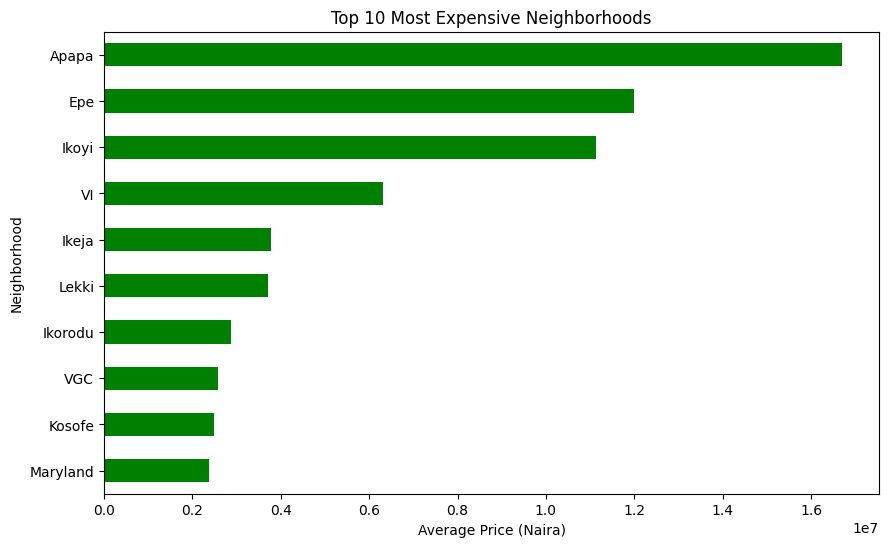

In [8]:
# The Top 10 most expensive neighborhood 
top_neighborhoods = df.groupby("Neighborhood")["Price"].mean().nlargest(10) # Group by neighborhood on the mean price

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
top_neighborhoods.sort_values().plot(kind="barh", ax=ax, color="green")
ax.set_xlabel("Average Price (Naira)")
ax.set_ylabel("Neighborhood")
ax.set_title("Top 10 Most Expensive Neighborhoods");

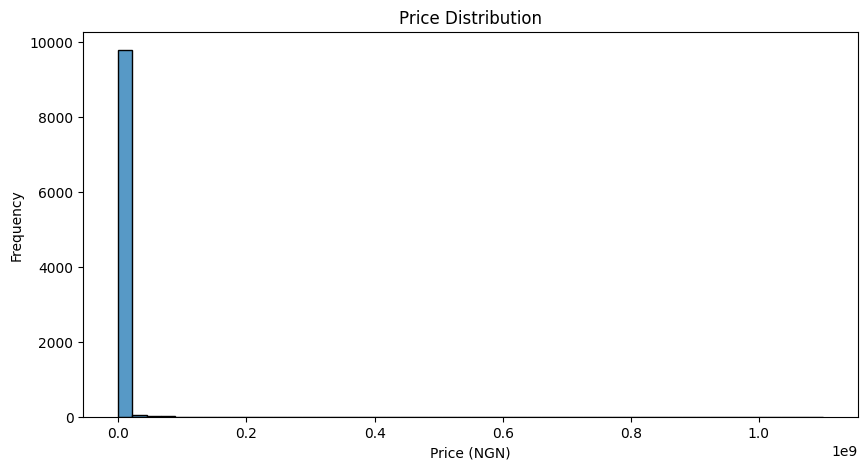

In [9]:
# Price distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["Price"], bins=50)
plt.title("Price Distribution")
plt.xlabel("Price (NGN)")
plt.ylabel("Frequency")
plt.show()

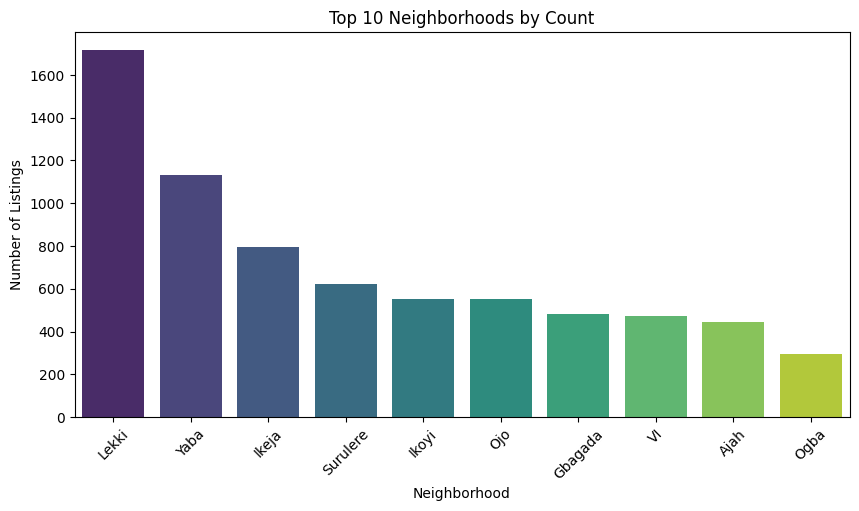

In [10]:
# Top 10 neighborhoods by count
top_neighborhoods = df["Neighborhood"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_neighborhoods.index, y=top_neighborhoods.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Neighborhoods by Count")
plt.ylabel("Number of Listings")
plt.show()


# Data Pre-processing

In [42]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "Pid"], inplace=True)

In [43]:
df.head(2)

,Price,Property_name,Address,Neighborhood
0,400000,1 bedroom mini flat Flat / Apartment for rent ...,Fidiso Estate Abijo Ajah Lagos,Ajah
1,14000000,3 bedroom Flat / Apartment for rent Gerrard Ge...,Gerrard Gerrard Gerard Road Ikoyi Lagos,Ikoyi


We need to split the Property_name and extract the bedroom numbers and type 

In [44]:
# Let's extract bedroom count and property type
def extract_property_details(property_name):
    words = property_name.split()
    
    # Let's extract first digit (number of bedrooms)
    num_bedrooms = None
    for word in words:
        if word.isdigit():
            num_bedrooms = int(word)
            break  # break the loop after finding the first number
    
    if num_bedrooms is None:
        num_bedrooms = np.nan  # return nan if value is missing
    
    # Extract property type (the word after "bedroom")
    if "bedroom" in words:
        bedroom_index = words.index("bedroom") # gets the index number of bedroom
        property_type = words[bedroom_index + 1] if bedroom_index + 1 < len(words) else "Unknown" # adds 1 to the index number and gets the word
    else:
        property_type = "Unknown" 

    return num_bedrooms, property_type

In [45]:
# Now let's create Bedroom and Property_type column by applying the function to all rows
df["Bedrooms"], df["Property_Type"]  = zip(*df["Property_name"].apply(extract_property_details))

In [46]:
df.head()

,Price,Property_name,Address,Neighborhood,Bedrooms,Property_Type
0,400000,1 bedroom mini flat Flat / Apartment for rent ...,Fidiso Estate Abijo Ajah Lagos,Ajah,1.0,mini
1,14000000,3 bedroom Flat / Apartment for rent Gerrard Ge...,Gerrard Gerrard Gerard Road Ikoyi Lagos,Ikoyi,3.0,Flat
2,200000,1 bedroom mini flat Flat / Apartment for rent ...,Obadia Akoka Yaba Lagos,Yaba,1.0,mini
3,800000,2 bedroom Flat / Apartment for rent Iju Ishaga...,surulere Iju Ishaga Road Gbaja Surulere Lagos,Surulere,2.0,Flat
4,300000,1 bedroom mini flat Flat / Apartment for rent ...,Close to Unilag Abule Oja Yaba Lagos,Yaba,1.0,mini


In [47]:
# Dropping the Property_name column
df.drop(columns=["Property_name"], inplace=True)

In [48]:
df.head(2)

,Price,Address,Neighborhood,Bedrooms,Property_Type
0,400000,Fidiso Estate Abijo Ajah Lagos,Ajah,1.0,mini
1,14000000,Gerrard Gerrard Gerard Road Ikoyi Lagos,Ikoyi,3.0,Flat


In [49]:
# lets confirm if there null values
df.isnull().sum()

Price              0
Address            0
Neighborhood       0
Bedrooms         930
Property_Type      0
dtype: int64

In [50]:
## filling the Bedrooms column null values with the median of the group they belong  
df["Bedrooms"] = df.groupby("Neighborhood")["Bedrooms"].transform(lambda x: x.fillna(x.median()))

In [51]:
df.isnull().sum()

Price            0
Address          0
Neighborhood     0
Bedrooms         1
Property_Type    0
dtype: int64

In [52]:
# filling the last row null value with the median of the columns
df["Bedrooms"].fillna(df["Bedrooms"].median(), inplace=True)

In [54]:
# Remove extreme outliers (1,000,000,000 (1 billion))
df = df[(df["Price"] > 100000) & (df["Price"] < 1e9) & (df['Bedrooms'] < 5)]

In [56]:
df = df.drop(df[(df['Neighborhood'].isin(['Lekki', 'Ajah', 'VI'])) & (df['Price'] < 1000000)].index)

# Training The Model

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [59]:
scaler = StandardScaler()
df["Price_Scaled"] = scaler.fit_transform(df[["Price"]])

In [60]:
# Train KNN model
model = NearestNeighbors(n_neighbors=5, metric="euclidean")
model.fit(df[["Price_Scaled"]])

NearestNeighbors(metric='euclidean')

# Recommendation System

In [61]:
# Function to recommend neighborhoods based on price at hand
def recommend_neighborhoods(price):
    price_scaled = scaler.transform([[price]])
    distances, indices = model.kneighbors(price_scaled)
    return df.iloc[indices[0]][["Address", "Neighborhood", "Price"]].reset_index(drop=True)

In [62]:
# Test it with 5000000
recommend_neighborhoods(900000)

,Address,Neighborhood,Price
0,Pedro road Palmgroove Shomolu Lagos,Shomolu,900000
1,Ocean Palm Estate Sangotedo Ajah Lagos,Sangotedo,900000
2,Chief Natufe Bode Thomas Surulere Lagos,Surulere,900000
3,Ocean Palm Estate Sangotedo Ajah Lagos,Sangotedo,900000
4,Ajao Estate Isolo Lagos,Isolo,900000


# Saving the model

In [63]:
import pickle

In [64]:
pickle.dump(model, open('Recommendation_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [65]:
# save the clean_data
clean_data = df.copy()

In [66]:
clean_data.to_csv('clean_data.csv')